# Custom map simulations

In this tutorial we will build a simulation from scratch.

We start by defining a `Band` that will determine our array's sensitivity to different spectra. We then generate an array by specifying a field of view, which will be populated by evenly-spaced beams of the given band.

In [1]:
import maria
from maria.instrument import Band

f090 = Band(
    center=90e9,  # in Hz
    width=20e9,  # in Hz
    NET_RJ=40e-6,  # in K sqrt(s)
    knee=1e0,    # in Hz
    gain_error=5e-2)

f150 = Band(
    center=150e9, 
    width=30e9, 
    NET_RJ=60e-6, 
    knee=1e0, 
    gain_error=5e-2)

Instrument(1 array)
├ arrays:
│             n     FOV baseline        bands polarized
│  array1  2116  29.85’      0 m  [f090,f150]     False
│ 
└ bands:
      name   center   width    η         NEP   NET_RJ     NET_CMB     FWHM
   0  f090   90 GHz  20 GHz  0.5  5.445 aW√s  40 uK√s  49.13 uK√s  0.5832’
   1  f150  150 GHz  30 GHz  0.5  12.25 aW√s  60 uK√s    104 uK√s      21”


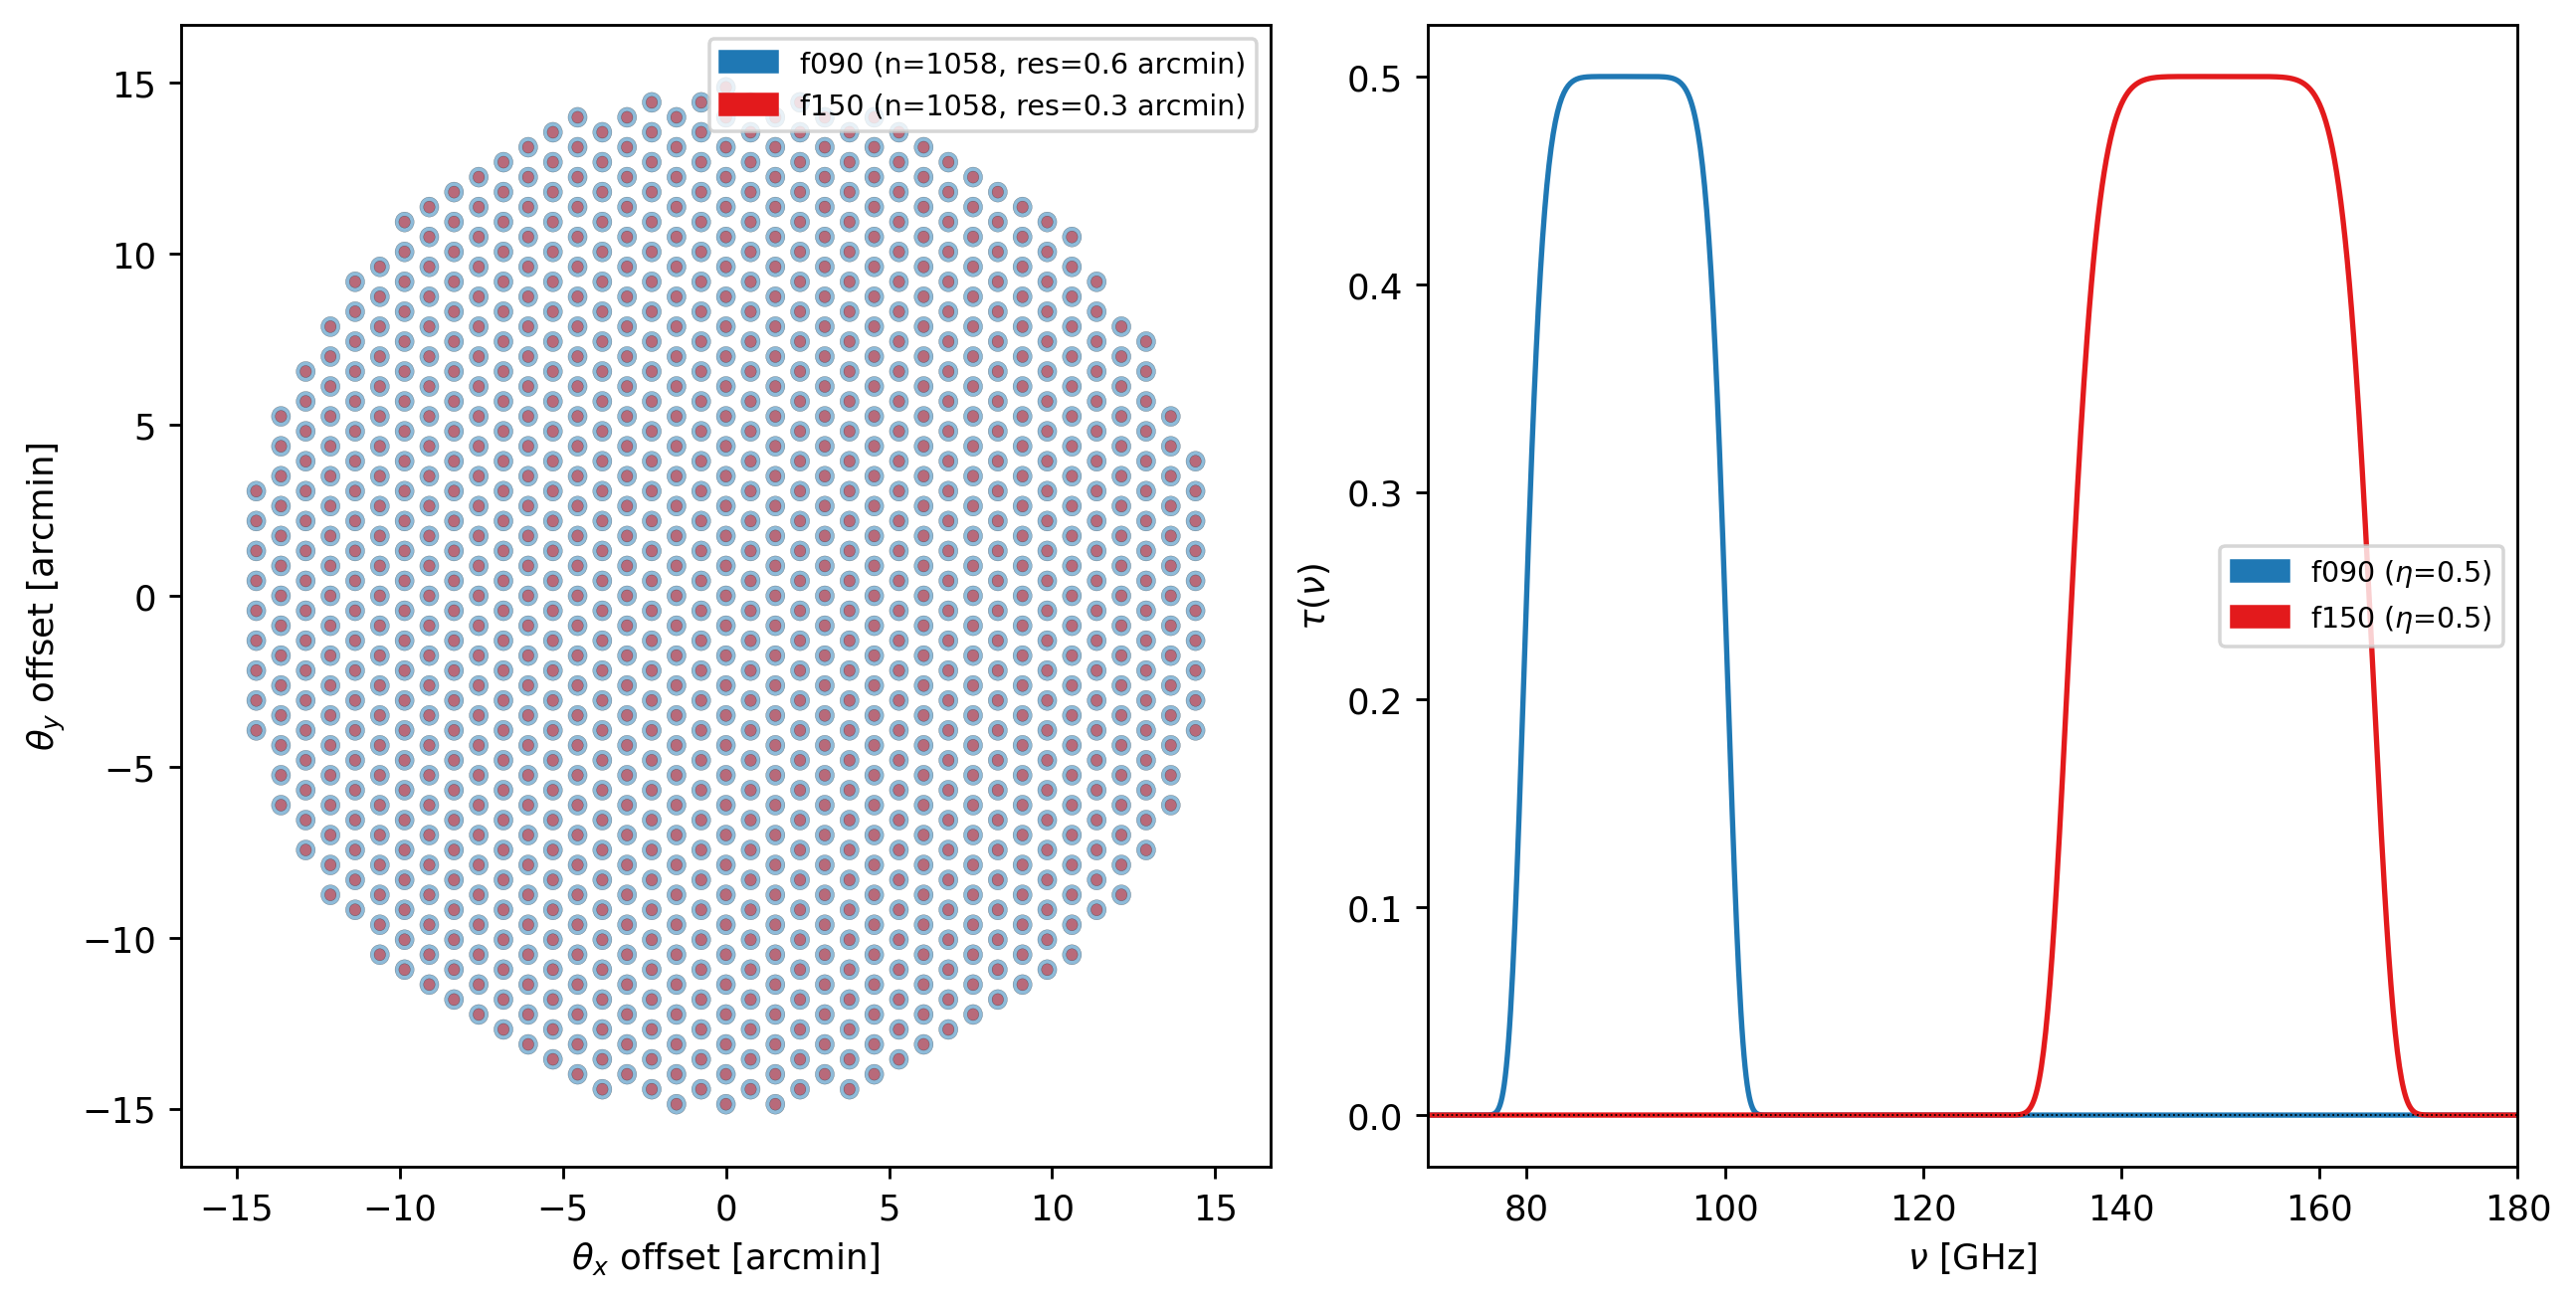

In [2]:
array = {"field_of_view": 0.5, 
         "shape": "circle", 
         "beam_spacing": 1.5,
         "primary_size": 25, 
         "bands": [f090, f150]}

instrument = maria.get_instrument(array=array)

print(instrument)
instrument.plot()

Here, the `fetch` function downloads a map to the path `map_filename`, but `map_filename` can be any `.h5` or `.fits` file of an image that corresponds to the `maria` map convention (see [Maps](https://thomaswmorris.com/maria/usage/inputs/maps)).

ProjectedMap:
  shape(nu, y, x): (1, 1024, 1024)
  stokes: naive
  nu: [150.] GHz
  t: naive
  z: naive
  quantity: spectral_flux_density_per_pixel
  units: Jy/pixel
    min: -3.845e-05
    max: -5.005e-08
  center:
    ra: 19ʰ24ᵐ37.44ˢ
    dec: -31°13’48.00”
  size(y, x): (1°, 1°)
  resolution(y, x): (3.516”, 3.516”)
  beam(maj, min, rot): (0°, 0°, 0°)
  memory: 16.78 MB


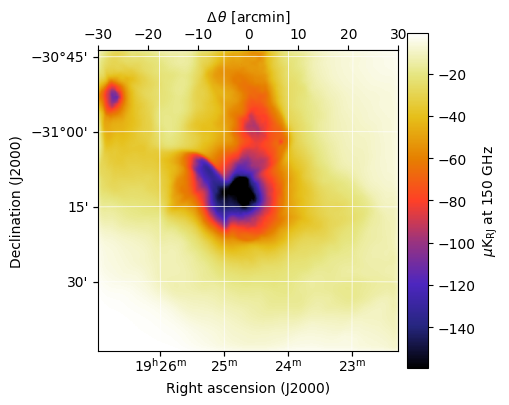

In [3]:
from maria.io import fetch

map_filename = fetch("maps/cluster1.fits")

input_map = maria.map.load(
    filename=map_filename,
    nu=150e9,
    center=(291.156, -31.23))
input_map.data *= 1e1

print(input_map)
input_map.to("K_RJ").plot()

Site:
  region: chajnantor
  location: 23°01’45.84”S 67°45’17.28”W
  altitude: 5065 m
  seasonal: True
  diurnal: True


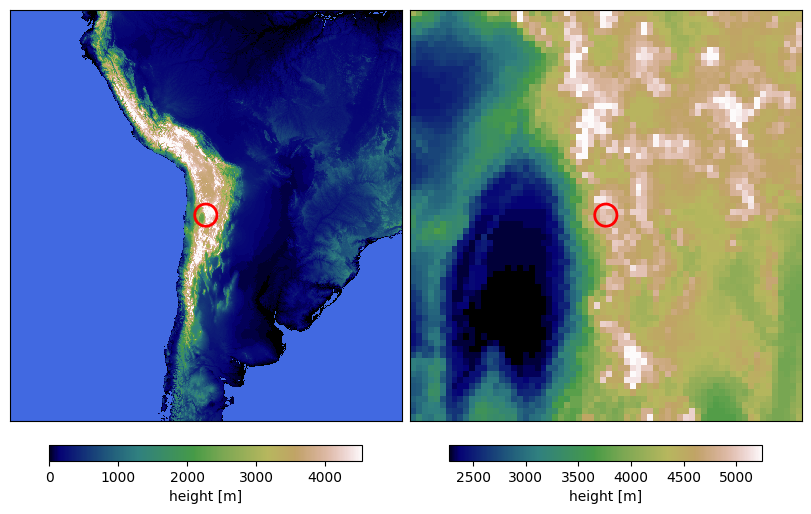

In [4]:
site = maria.get_site("llano_de_chajnantor", altitude=5065)

print(site)
site.plot()

Plan:
  start_time: 2024-08-06 03:00:00.000 +00:00
  duration: 900 s
  sample_rate: 50 Hz
  center:
    ra: 19ʰ24ᵐ37.44ˢ
    dec: -31°13’48.00”
  scan_pattern: daisy
  scan_radius: 0.9989°
  scan_kwargs: {'radius': 0.5, 'speed': 0.1}


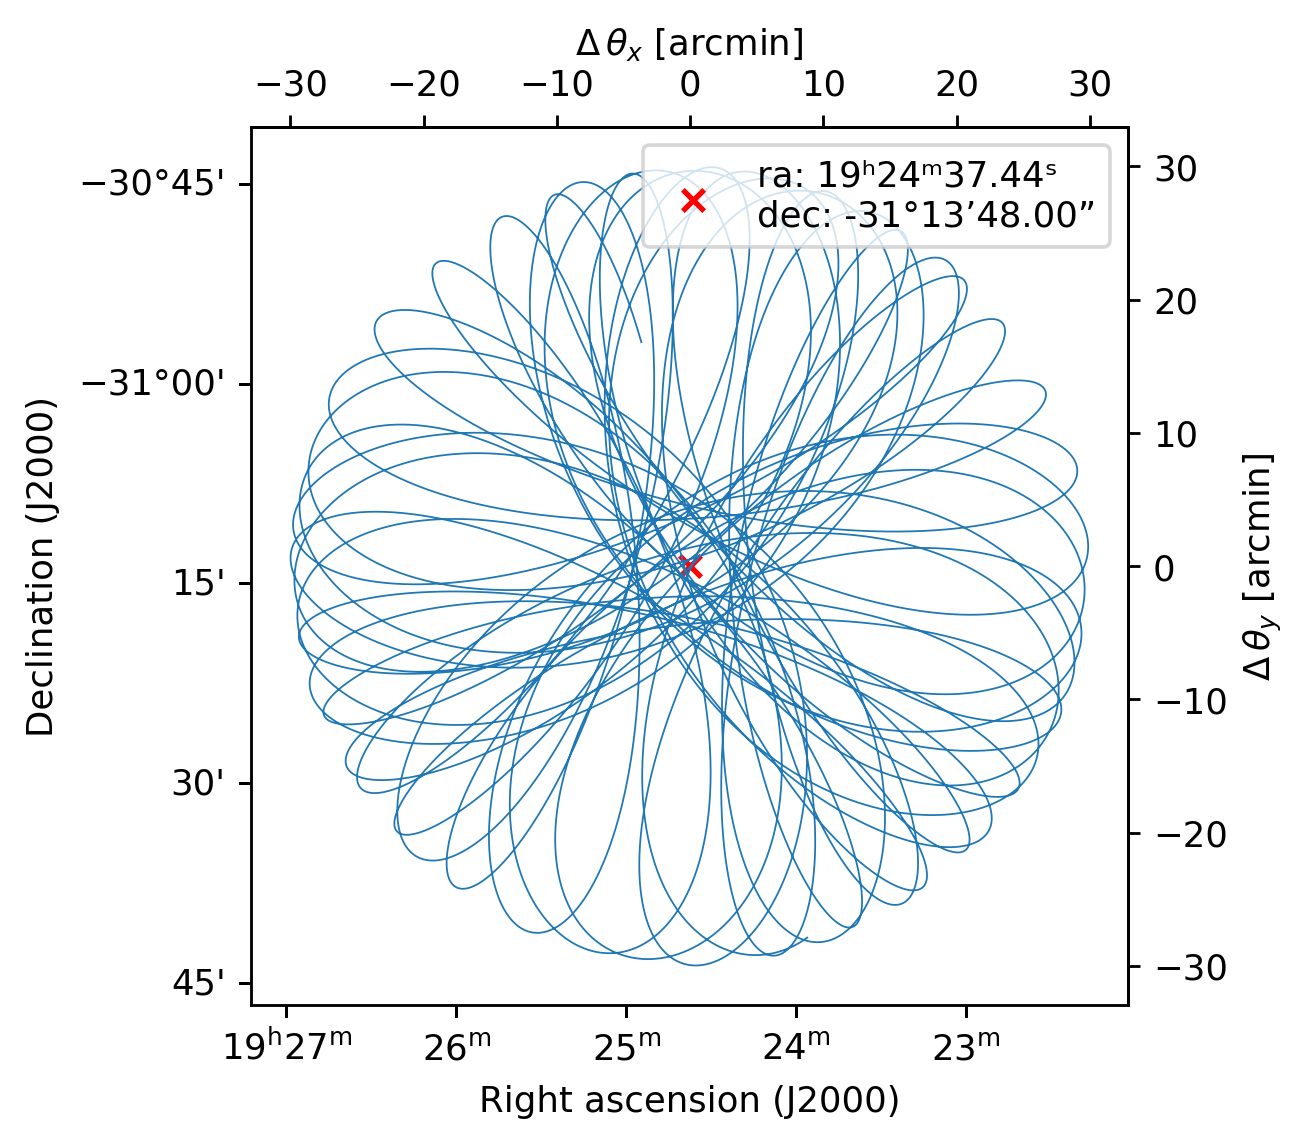

In [5]:
plan = maria.Plan(
    start_time="2024-08-06T03:00:00",
    scan_pattern="daisy",
    scan_options={"radius": 0.5, "speed": 0.1},  # in degrees
    duration=900,  # in seconds
    sample_rate=50,  # in Hz
    scan_center=(291.156, -31.23),
    frame="ra_dec")

print(plan)
plan.plot()

In [6]:
sim = maria.Simulation(
    instrument,
    plan=plan,
    site=site,
    atmosphere="2d",
    atmosphere_kwargs={"weather": {"pwv": 0.5}},
    map=input_map)

print(sim)

Constructing atmosphere:   0%|          | 0/10 [00:00<?, ?it/s]

Constructing atmosphere:  10%|█         | 1/10 [00:05<00:52,  5.78s/it]

Constructing atmosphere:  20%|██        | 2/10 [00:11<00:46,  5.76s/it]

Constructing atmosphere:  30%|███       | 3/10 [00:17<00:39,  5.68s/it]

Constructing atmosphere:  40%|████      | 4/10 [00:22<00:33,  5.58s/it]

Constructing atmosphere:  50%|█████     | 5/10 [00:27<00:27,  5.52s/it]

Constructing atmosphere:  60%|██████    | 6/10 [00:33<00:22,  5.56s/it]

Constructing atmosphere:  70%|███████   | 7/10 [00:39<00:17,  5.69s/it]

Constructing atmosphere:  80%|████████  | 8/10 [00:45<00:11,  5.72s/it]

Constructing atmosphere:  90%|█████████ | 9/10 [00:51<00:05,  5.94s/it]

Constructing atmosphere: 100%|██████████| 10/10 [00:57<00:00,  6.01s/it]

Constructing atmosphere: 100%|██████████| 10/10 [00:57<00:00,  5.79s/it]

Simulation
├ Instrument(1 array)
│ ├ arrays:
│ │             n     FOV baseline        bands polarized
│ │  array1  2116  29.85’      0 m  [f090,f150]     False
│ │ 
│ └ bands:
│       name   center   width    η         NEP   NET_RJ     NET_CMB     FWHM
│    0  f090   90 GHz  20 GHz  0.5  5.445 aW√s  40 uK√s  49.13 uK√s  0.5832’
│    1  f150  150 GHz  30 GHz  0.5  12.25 aW√s  60 uK√s    104 uK√s      21”
├ Site:
│   region: chajnantor
│   location: 23°01’45.84”S 67°45’17.28”W
│   altitude: 5065 m
│   seasonal: True
│   diurnal: True
├ Plan:
│   start_time: 2024-08-06 03:00:00.000 +00:00
│   duration: 900 s
│   sample_rate: 50 Hz
│   center:
│     ra: 19ʰ24ᵐ37.44ˢ
│     dec: -31°13’48.00”
│   scan_pattern: daisy
│   scan_radius: 0.9989°
│   scan_kwargs: {'radius': 0.5, 'speed': 0.1}
├ Atmosphere(10 processes with 10 layers):
│ ├ spectrum:
│ │   region: chajnantor
│ └ weather:
│     region: chajnantor
│     altitude: 5065 m
│     time: Aug 5 23:07:29 -04:00
│     pwv[mean, rms]: (0.5 mm,

Generating turbulence:   0%|          | 0/10 [00:00<?, ?it/s]

Generating turbulence:  30%|███       | 3/10 [00:00<00:00, 21.21it/s]

Generating turbulence:  60%|██████    | 6/10 [00:00<00:00, 15.36it/s]

Generating turbulence:  80%|████████  | 8/10 [00:00<00:00, 12.75it/s]

Generating turbulence: 100%|██████████| 10/10 [00:00<00:00, 10.71it/s]

Generating turbulence: 100%|██████████| 10/10 [00:00<00:00, 12.12it/s]

Sampling turbulence:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling turbulence:  10%|█         | 1/10 [00:02<00:21,  2.41s/it]

Sampling turbulence:  20%|██        | 2/10 [00:04<00:18,  2.35s/it]

Sampling turbulence:  30%|███       | 3/10 [00:07<00:16,  2.34s/it]

Sampling turbulence:  40%|████      | 4/10 [00:09<00:14,  2.34s/it]

Sampling turbulence:  50%|█████     | 5/10 [00:11<00:11,  2.34s/it]

Sampling turbulence:  60%|██████    | 6/10 [00:14<00:09,  2.37s/it]

Sampling turbulence:  70%|███████   | 7/10 [00:16<00:07,  2.40s/it]

Sampling turbulence:  80%|████████  | 8/10 [00:19<00:04,  2.40s/it]

Sampling turbulence:  90%|█████████ | 9/10 [00:21<00:02,  2.41s/it]

Sampling turbulence: 100%|██████████| 10/10 [00:23<00:00,  2.42s/it]

Sampling turbulence: 100%|██████████| 10/10 [00:23<00:00,  2.39s/it]

Computing atmospheric emission:   0%|          | 0/2 [00:00<?, ?it/s]

Computing atmospheric emission:   0%|          | 0/2 [00:00<?, ?it/s, band=f090]

Computing atmospheric emission:  50%|█████     | 1/2 [00:08<00:08,  8.99s/it, band=f090]

Computing atmospheric emission:  50%|█████     | 1/2 [00:08<00:08,  8.99s/it, band=f150]

Computing atmospheric emission: 100%|██████████| 2/2 [00:17<00:00,  8.89s/it, band=f150]

Computing atmospheric emission: 100%|██████████| 2/2 [00:17<00:00,  8.91s/it, band=f150]

Sampling map:   0%|          | 0/2 [00:00<?, ?it/s]

Sampling map:   0%|          | 0/2 [00:00<?, ?it/s, band=f090]

Sampling map:   0%|          | 0/2 [00:06<?, ?it/s, channel=[ 0. inf] Hz]

Sampling map:  50%|█████     | 1/2 [00:15<00:15, 15.90s/it, channel=[ 0. inf] Hz]

Sampling map:  50%|█████     | 1/2 [00:15<00:15, 15.90s/it, band=f150]           

Sampling map:  50%|█████     | 1/2 [00:22<00:15, 15.90s/it, channel=[ 0. inf] Hz]

Sampling map: 100%|██████████| 2/2 [00:31<00:00, 15.76s/it, channel=[ 0. inf] Hz]

Sampling map: 100%|██████████| 2/2 [00:31<00:00, 15.78s/it, channel=[ 0. inf] Hz]

Generating noise:   0%|          | 0/2 [00:00<?, ?it/s]

Generating noise:   0%|          | 0/2 [00:00<?, ?it/s, band=f090]

Generating noise:  50%|█████     | 1/2 [00:01<00:01,  1.77s/it, band=f090]

Generating noise:  50%|█████     | 1/2 [00:01<00:01,  1.77s/it, band=f150]

Generating noise: 100%|██████████| 2/2 [00:03<00:00,  1.63s/it, band=f150]

Generating noise: 100%|██████████| 2/2 [00:03<00:00,  1.65s/it, band=f150]

TOD(shape=(2116, 45000), fields=['atmosphere', 'map', 'noise'], units='pW', start=2024-08-06 03:14:59.979 +00:00, duration=900.0s, sample_rate=50.0Hz, metadata={'atmosphere': True, 'sim_time': <Arrow [2025-06-06T17:35:02.840983+00:00]>, 'altitude': 5065.0, 'region': 'chajnantor', 'pwv': 0.5, 'base_temperature': 272.523})


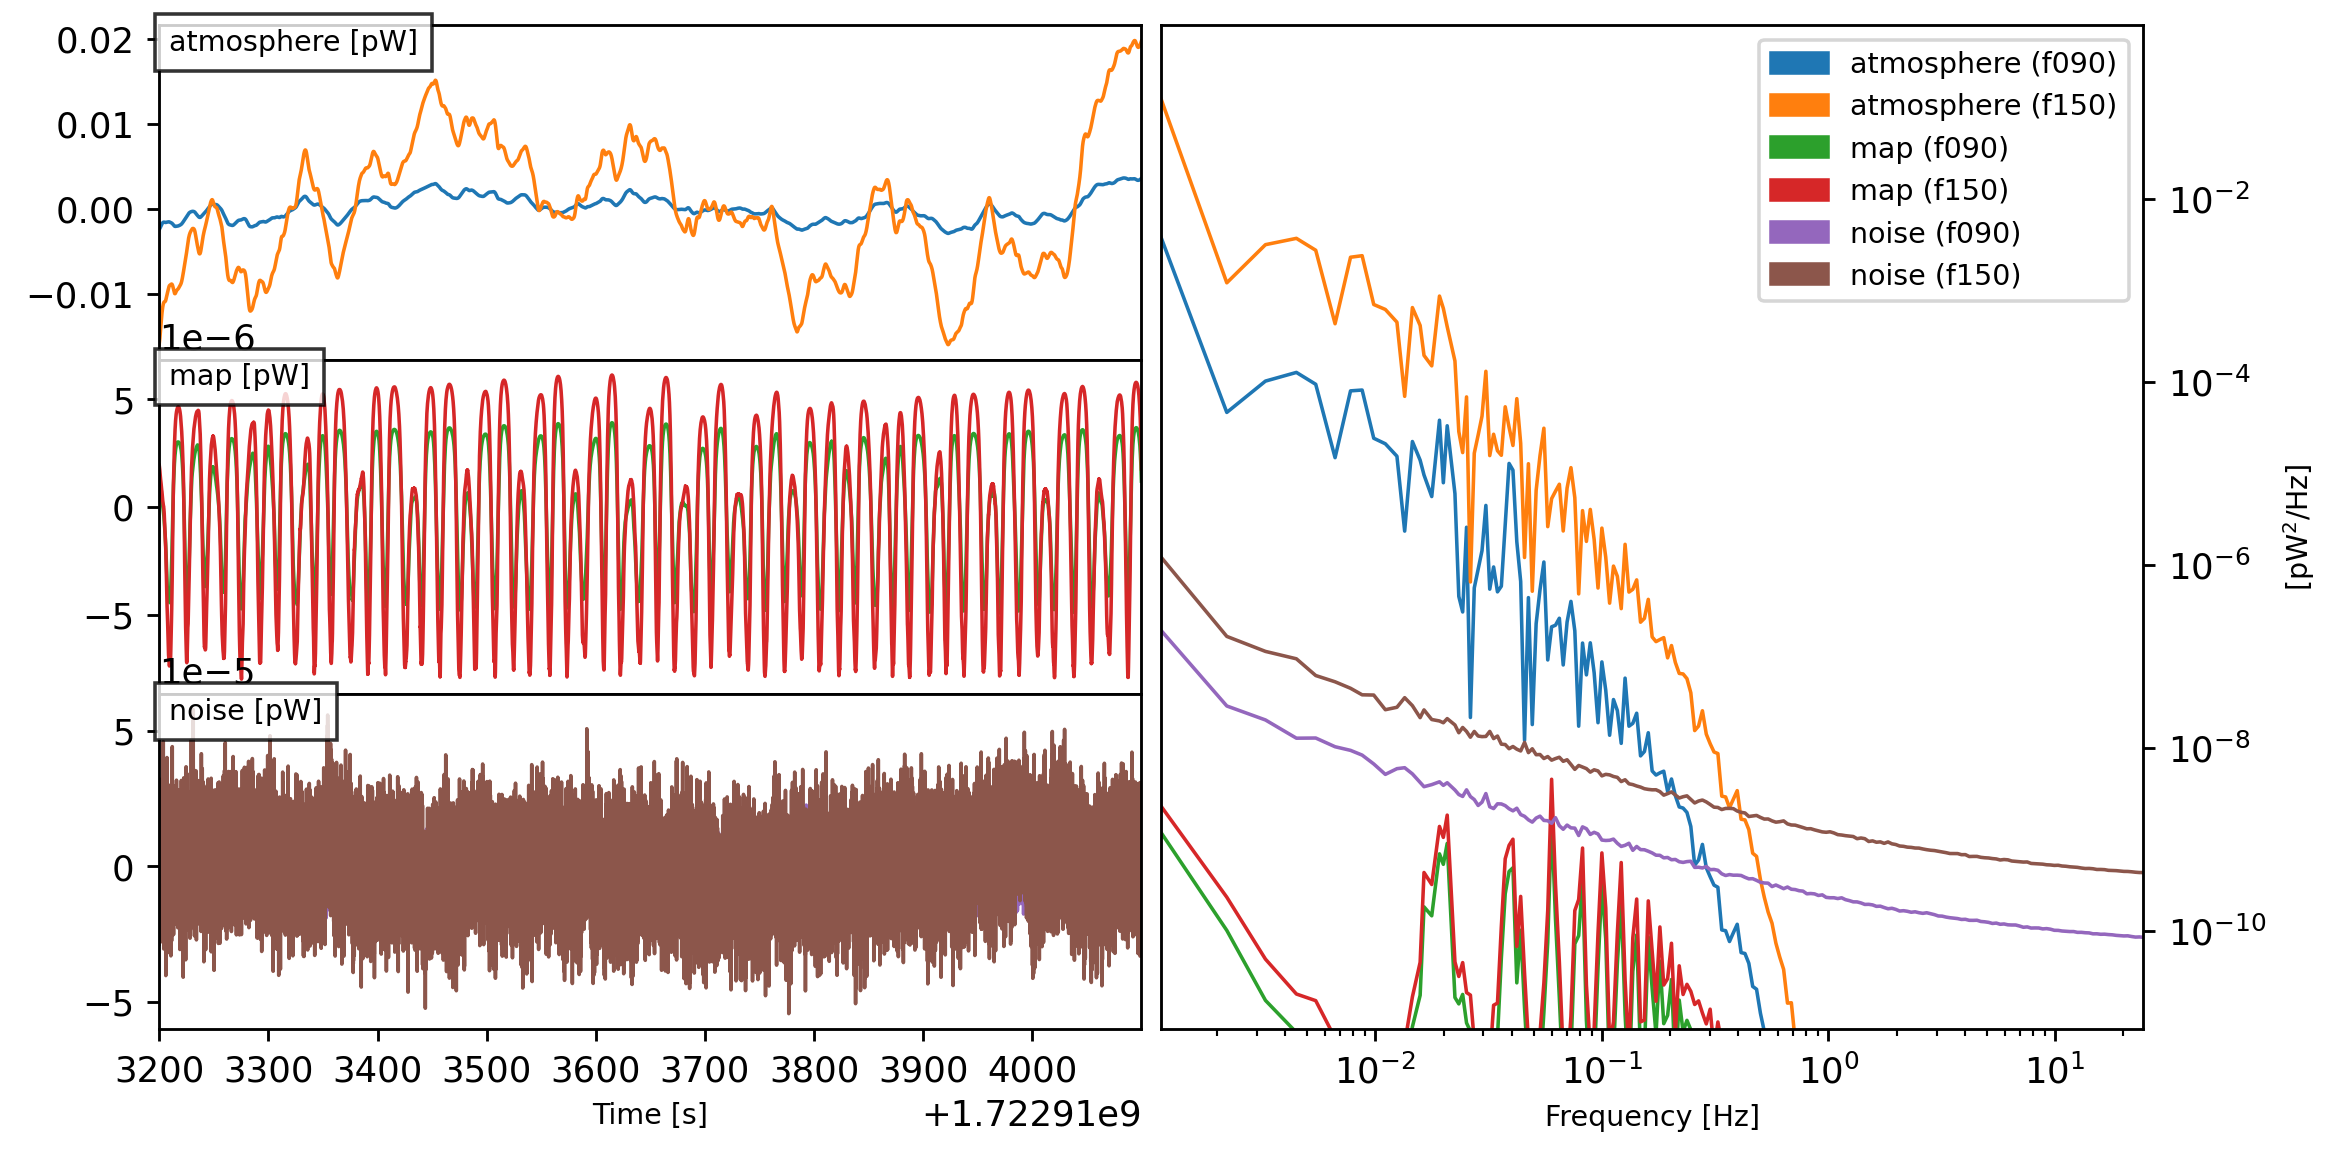

In [7]:
tod = sim.run()

print(tod)
tod.plot()

In [8]:
from maria.mappers import BinMapper

mapper = BinMapper(
    center=(291.156, -31.23),
    frame="ra_dec",
    width=1.,
    height=1.,
    resolution=1. / 256,
    tod_preprocessing={
        "window": {"name": "tukey", "kwargs": {"alpha": 0.1}},
        "remove_spline": {"knot_spacing": 30, "remove_el_gradient": True},
        "remove_modes": {"modes_to_remove": [0]},
    },
    map_postprocessing={
        "gaussian_filter": {"sigma": 1},
    },
    units="mK_RJ",
)

mapper.add_tods(tod)

output_map = mapper.run()

Mapping band f090:   0%|          | 0/1 [00:00<?, ?it/s]

Mapping band f090:   0%|          | 0/1 [00:00<?, ?it/s, band=f090, stokes=I]

Mapping band f090: 100%|██████████| 1/1 [00:00<00:00,  2.29it/s, band=f090, stokes=I]

Mapping band f090: 100%|██████████| 1/1 [00:00<00:00,  2.28it/s, band=f090, stokes=I]


2025-06-06 17:35:30.699 INFO: Ran mapper for band f090 in 21.89 s.


Mapping band f150:   0%|          | 0/1 [00:00<?, ?it/s]

Mapping band f150:   0%|          | 0/1 [00:00<?, ?it/s, band=f150, stokes=I]

Mapping band f150: 100%|██████████| 1/1 [00:00<00:00,  2.34it/s, band=f150, stokes=I]

Mapping band f150: 100%|██████████| 1/1 [00:00<00:00,  2.33it/s, band=f150, stokes=I]


2025-06-06 17:35:51.350 INFO: Ran mapper for band f150 in 20.65 s.


We can see the recovered map with

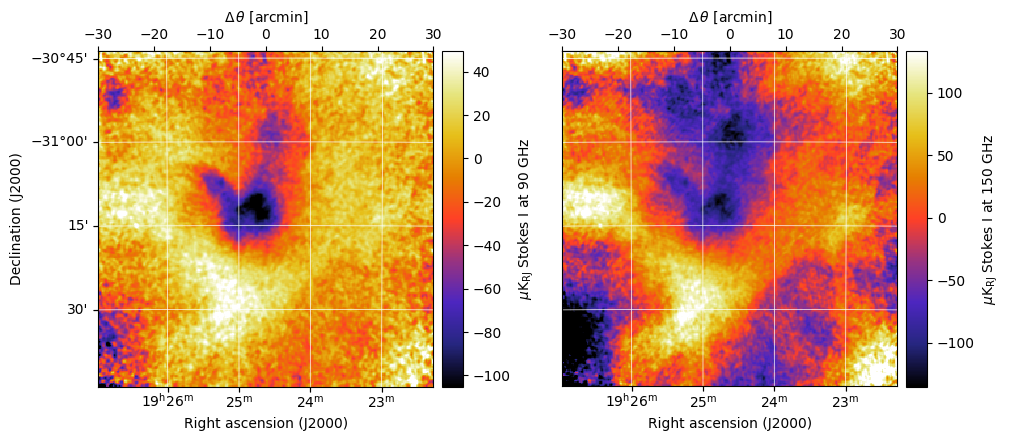

In [9]:
output_map.plot(nu_index=[0, 1])